# Mini-Project 1

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

!pip install antspyx
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json

Gtk-Message: 12:49:24.708: Failed to load module "canberra-gtk-module"


## Usefull functions

In [2]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

In [4]:
###############
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
loadFSL()
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()


(ipykernel_launcher.py:510): Gdk-WARNING **: 12:50:38.866: gdkdrawable-x11.c:952 drawable is not a pixmap or window


# Visualization of the data in FSL

In [5]:
fsleyesDisplay.load(op.expandvars('/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/T1w/T1w'))

In [7]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars('/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/fMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR'))

In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars('/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/fMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL'))

# Use BIDS standard

In [5]:
dataset_id = 'subject101410'
subject = '101410' 

sample_path = "/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

subject_dir = 'sub-{}'.format(subject)

anat_dir = op.join(bids_root,subject_dir,"anat")
func_dir = op.join(bids_root,subject_dir,"func")

#### TO RUN ONLY IF YOU DON'T HAVE THE STRUCTURE

In [16]:
mkdir_no_exist(bids_root)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-101410'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'fmap'))

In [18]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|------------ fmap/
|------------ func/
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii
|--- sub-101410/
|------ anat/
|------ func/


#### Now, we have to place the files we have downloaded before in the good directories according to the BIDS standard
#### TO RUN ONLY IF YOU DON'T HAVE THE STRUCTURE

In [19]:
import shutil

# Create the anat and func folders
os.makedirs(anat_dir, exist_ok=True)
os.makedirs(func_dir, exist_ok=True)

anat_src = op.join(bids_root, "T1w", "T1w.nii.gz")
func_root = op.join(bids_root, "fMRI")

# Déplacer et renommer le T1w
anat_dest = op.join(anat_dir, f"sub-{subject}_T1w.nii.gz")
shutil.copy(anat_src, anat_dest)

# Gérer les deux runs fMRI (LR et RL)
fmri_tasks = {
    "tfMRI_MOTOR_LR": "motorLR",
    "tfMRI_MOTOR_RL": "motorRL"
}

for folder, task_name in fmri_tasks.items():
    func_path = op.join(func_root, folder)
    bold_src = op.join(func_path, f"{folder}.nii")
    events_src = op.join(func_path, f"events_{folder.split('_')[-1]}.csv")

    bold_dest = op.join(func_dir, f"sub-{subject}_task-{task_name}_bold.nii")
    events_dest = op.join(func_dir, f"sub-{subject}_task-{task_name}_events.tsv")

    shutil.copy(bold_src, bold_dest)
    shutil.copy(events_src, events_dest)

In [22]:
print_dir_tree(bids_root, max_depth=4)

|subject101410/
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|------------ fmap/
|------------ func/
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii
|--- sub-101410/
|------ anat/
|--------- sub-101410_T1w.nii.gz
|------ func/
|--------- sub-101410_task-motorLR_bold.nii
|--------- sub-101410_task-motorLR_events.tsv
|--------- sub-101410_task-motorRL_bold.nii
|--------- sub-101410_task-motorRL_events.tsv


#### Nice! All the files are at the right place with the right name (we don't need the T1w and fMRI folders anymore)

# 1. structural preprocessing

## Skull-Stripping

In [23]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping (you'll learn more about it next week!).
    # For now all you need to do is that we remove the bones and flesh from the MRI to get the brain!
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "101410", robust = True)  # To improve the fit

Done with BET.


In [24]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(anat_dir,"sub-101410_T1w"))
fsleyesDisplay.load(resulting_mask_path)

#### Look how good the mask fits the brain. Do manual correction in FSL if needed (see Lab 2)

### Applying the mask

In [25]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    ###########################
    # Solution
    # By reading fslmaths documentation, one can see that the -mas option is exactly what we desire.
    ###########################
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask.nii.gz') # The mask to use

########################
apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [26]:
#fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

## Segmentation

Takes a long time to run

In [27]:
anatomical_path = op.join(bids_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz')
bet_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w')

#########################
# We must apply FAST to the brain-extracted image. Thus we must use the BET path brain.
##########################
fast_target = bet_path 

[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-101410', 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

In [28]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--- sub-101410/
|------ anat/
|--------- sub-101410_T1w.nii.gz
|------ func/
|--------- sub-101410_task-motorLR_bold.nii
|--------- sub-101410_task-motorLR_events.tsv
|--------- sub-101410_task-motorRL_bold.nii
|--------- sub-101410_task-motorRL_events.tsv


The pve files correspond to our segmented tissues. We have exactly three files, because we set n_classes to 3 above:
```python
fast(..., n_classes=3)
```

Let's try to identify which segmentation is which tissue type in the brain. To do this, you'll have to visualize the tissues and decide for yourself.

To make it easier on you, we will display:

- pve_0 in <span style="color:red;">red</span> --> cerebrospinal fluid
- pve_1 in <span style="color:green;">green</span> --> grey matter
- pve_2 in <span style="color:blue;">blue</span> --> white matter

In [20]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

# 2. Functional preprocessing

In [29]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(func_dir,"sub-101410_task-motorLR_bold"))

## Concatenating

Before merging both runs together, we want to rescale them. The reason is that different runs can have different overall signal intensities or variances, because of: scanner gain or baseline drift, physiological noise changes or small differences in acquisition or head position. 

In [11]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from nilearn.image import concat_imgs, new_img_like
import matplotlib.pyplot as plt

# Raw fMRI runs
runs_info = [
    ('sub-101410_task-motorLR', 'sub-101410_task-motorLR_bold.nii', 'sub-101410_task-motorLR_events.tsv'),
    ('sub-101410_task-motorRL', 'sub-101410_task-motorRL_bold.nii', 'sub-101410_task-motorRL_events.tsv')
]

# Output folder for preprocessed/scaled runs
output_dir = os.path.join(preproc_root, 'sub-101410', 'func')
os.makedirs(output_dir, exist_ok=True)

concatenated_imgs = []
concatenated_events = []

total_duration = 0  # time offset accumulator for concatenation
TR = 0.72

for run_name, run_file, events_file in runs_info:
    run_path = os.path.join(bids_root, 'sub-101410', 'func', run_file)
    events_path = os.path.join(bids_root, 'sub-101410', 'func', events_file)

    # ----- Load & scale image -----
    img = nib.load(run_path)
    data = img.get_fdata(dtype=np.float32)
    
    # Brain mask and scaling
    brain_mask = data > 0
    global_var = np.var(data[brain_mask], dtype=np.float64)
    scaled_data = data / np.sqrt(global_var)
    del data
    
    new_img = new_img_like(img, scaled_data)
    concatenated_imgs.append(new_img)
    del scaled_data

    # ----- Load & shift events -----
    events = pd.read_csv(events_path, sep=",")

    # determine run duration in seconds
    n_volumes = img.shape[3]
    run_duration = n_volumes * TR + 0.02

    # shift onsets by total_duration so events align with concatenated fMRI
    events['onset'] = events['onset'] + total_duration

    concatenated_events.append(events)

    # update for next run
    total_duration += run_duration


# ----- Save concatenated NIfTI -----
concat_img = concat_imgs(concatenated_imgs)
concat_img.to_filename(os.path.join(output_dir, 'sub-101410_task-motor_concat.nii.gz'))

# ----- Save concatenated events -----
merged_events = pd.concat(concatenated_events, ignore_index=True)
merged_events.to_csv(os.path.join(output_dir, 'sub-101410_task-motor_concat_events.tsv'), sep="\t", index=False)


We have now merged the two runs of both the .nii files and the event files (needed for the GLM later on).

In [33]:
concat_path = os.path.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat.nii.gz')
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(concat_path)

Text(0, 0.5, 'Mean voxel intensity')

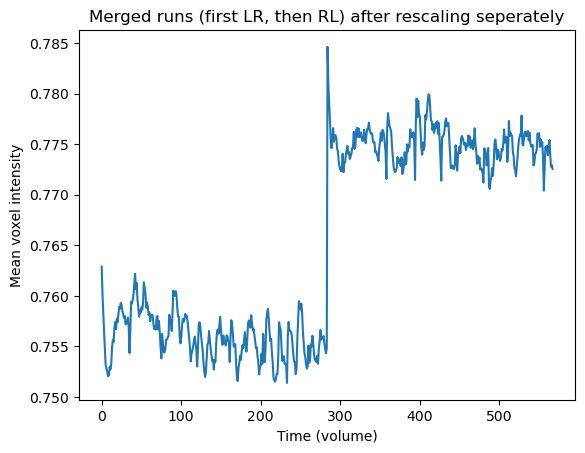

In [6]:
import matplotlib.pyplot as plt
import nibabel as nib
import os.path as op

mean = nib.load(op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat.nii.gz')).get_fdata().mean(axis=(0,1,2))

plt.plot(mean)
plt.title('Merged runs (first LR, then RL) after rescaling seperately')
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In the mean voxel intensity plot above we can distinctly separate between the two runs (LR and RL). The jump betweeen them is roughly 0.03

## Motion correction

Attention: By default, MCFLIRT selects the middle volume of the EPI serie as reference to which other volumes are realigned.

In [9]:
from fsl.wrappers import mcflirt

path_original_data = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat')
path_moco_data = os.path.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [284] to 8 mm pixels
Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][40

refnum = 284
Original_refvol = -1


Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][478][479][

{}

In [10]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)


(ipykernel_launcher.py:4599): Gdk-WARNING **: 10:37:54.647: gdkdrawable-x11.c:952 drawable is not a pixmap or window


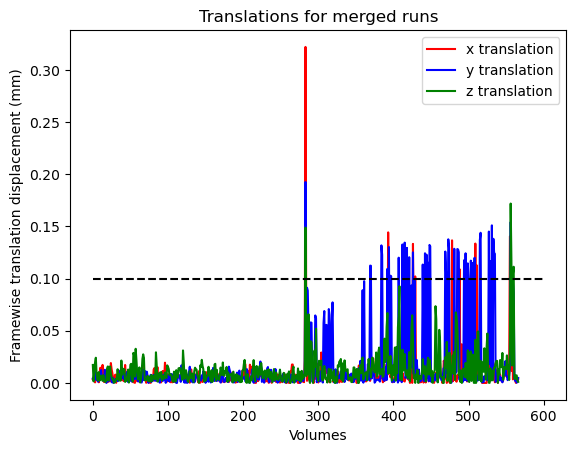

In [7]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_moco.par'))

# Getting the translation is easy
trans_x = mot_params["Translation x"]
trans_y = mot_params["Translation y"]
trans_z = mot_params["Translation z"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
disp_y = np.diff(trans_y)
disp_z = np.diff(trans_z)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.1
plt.plot(np.abs(disp_x), 'r', label='x translation')
plt.plot(np.abs(disp_y), 'b', label='y translation')
plt.plot(np.abs(disp_z), 'g', label='z translation')

plt.legend()

plt.hlines(threshold, 0, 600,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.title("Translations for merged runs")
plt.show()

By observing the translation plot, we can clearly see the big jump from run LR to run RL. This shows us, that the reference image chosen by MCFLIRT must be part of the first run (LR).

## Gaussian smoothing

I am unsure on how to determine the size of our filter. Currently it is 6 mm

In [10]:
import subprocess
output_path = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_moco')

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_moco', '-s', '2.547987090198743', '/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_moco_smoothed-6mm'], returncode=0)

In [11]:
smoothed_path = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_moco_smoothed-6mm')
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path)
fsleyesDisplay.load(smoothed_path)

# 3. GLM

In [26]:
events_path = os.path.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_events.tsv')
events = pd.read_csv(events_path, sep="\t")
print(events.columns)
events

Index(['onset', 'duration', 'condition'], dtype='object')


,onset,duration,condition
0,0.0,8.0,NaN
1,8.0,3.0,cue
2,11.0,12.0,rh
3,23.0,3.0,cue
4,26.0,12.0,lf
5,38.0,3.0,cue
6,41.0,12.0,t
7,53.0,3.0,cue
8,56.0,12.0,rf
9,68.0,3.0,cue


For some reason the NaN Condition causes problems as it is read by the GLM fit as a duplicate. The NaN condition only appears at the beginning of each run, so for the construction of the design matrix i ignored it.

In [28]:
# Rename column for Nilearn
events_clean.rename(columns={'condition': 'trial_type'}, inplace=True)

# Ignore lines with NaN
baseline_rows = [0, 24]
events.loc[baseline_rows, 'trial_type'] = np.nan

training a glm model:

In [51]:
# Rename the column 'condition' -> 'trial_type'
events_clean.rename(columns={'condition': 'trial_type'}, inplace=True)

from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
fmri_img = nib.load(op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat.nii.gz'))
# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=0.72,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm', 
                           drift_model='polynomial',# adding drift model directly 
                           drift_order=3,
                          )

In [55]:
# determining the number of scanns per run (the same for both runs)
n_scan_run = nib.load(op.join(func_dir, 'sub-101410_task-motorRL_bold.nii')).shape[3]
run1_reg = np.zeros(2 * n_scan_run)
run2_reg = np.zeros(2 * n_scan_run)
run1_reg[:n_scan_run] = 1
run2_reg[n_scan_run:] = 1

reg_names = ['run1_LR_baseline', 'run2_RL_baseline']
extra_regs = [run1_reg, run2_reg]


import pandas as pd
confounds = pd.DataFrame(np.column_stack([run1_reg, run2_reg]),
                         columns=['run1_LR_baseline', 'run2_RL_baseline'])

# Fit the model to our design and data after adding 2 further regressors
fmri_glm = fmri_glm.fit(fmri_img, events=events_clean, confounds=confounds)

/opt/conda/lib/python3.11/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


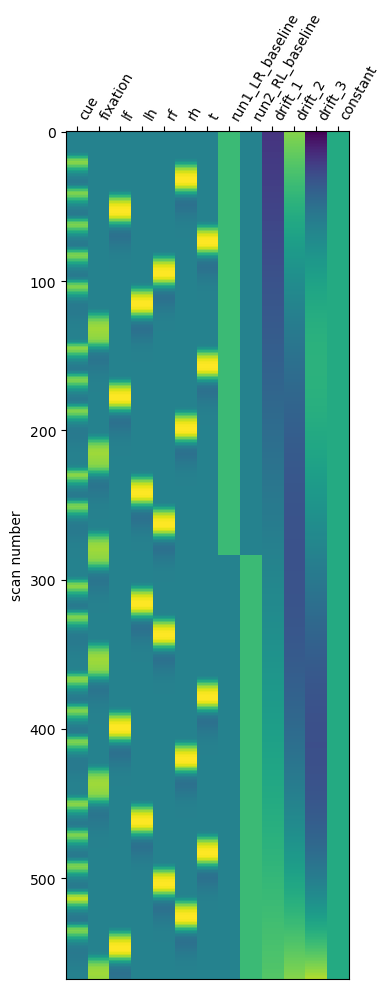

In [56]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

## Conditions

In [92]:
# Create the dictionary of the conditions

conditions = {
    'lh': np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]), # left hand
    'rh': np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]), # right hand
    'lf': np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), # left foot
    'rf': np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]), # right foot
    't': np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), # tongue
    'fix': np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), # fixation
    'cue': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # cue
}

hand_minus_foot = 0.5*conditions['lh'] + 0.5*conditions['rh'] - 0.5*conditions['lf'] - 0.5*conditions['rf']
right_minus_left = 0.5*conditions['rh'] + 0.5*conditions['rf'] - 0.5*conditions['lh'] - 0.5*conditions['lf']
right_hand = conditions['rh'] - conditions['fix']
left_hand = conditions['lh'] - conditions['fix']
tongue = conditions['t'] - conditions['fix']

## Calculating and Plotting Contrast

In [96]:
# Defining the contrast function 

def plot_contrast(condition, name, cut_coords, cluster_size, fdr_rate):
    z_map = fmri_glm.compute_contrast(condition,
                                  output_type='z_score')
    
    # Here, we apply the FDR correction + threshold
    clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
    
    # And this is just to plot here!
    plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
                  display_mode='z', cut_coords=cut_coords, black_bg=True,
                  title='{} (fdr={}, threshold={}), clusters > {} voxels'.format(name, fdr_rate, threshold, cluster_size))
    plt.show()
    

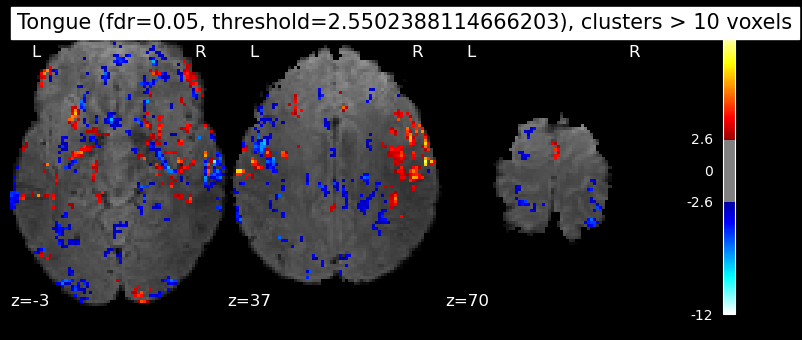

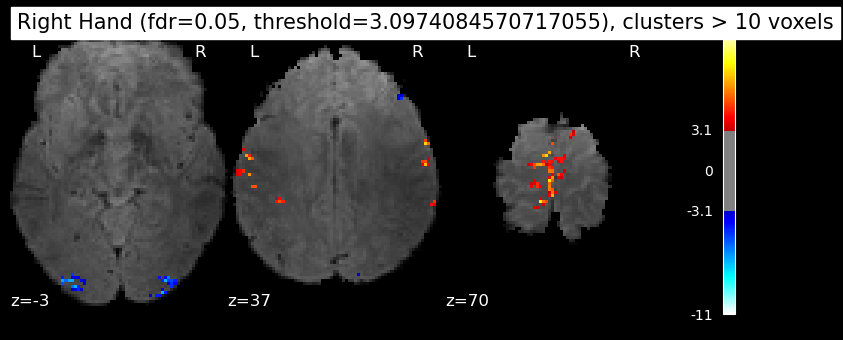

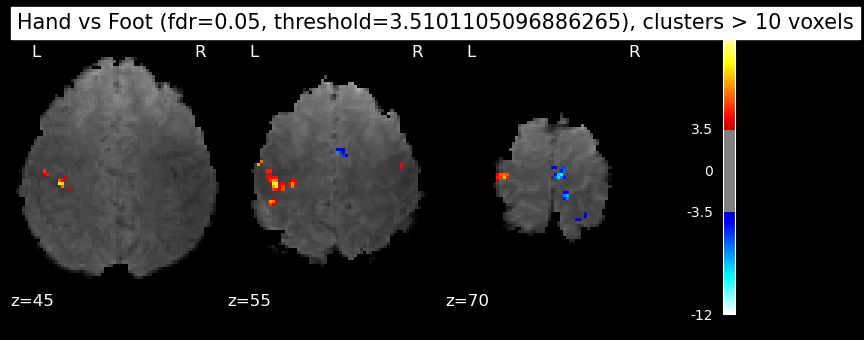

In [99]:
import nibabel as nib
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
cluster_size = 10 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!
cut_coords = [-3,37,70]

plot_contrast(tongue, 'Tongue', cut_coords, cluster_size, fdr_rate)
plot_contrast(right_hand, 'Right Hand', cut_coords, cluster_size, fdr_rate)
plot_contrast(hand_minus_foot, 'Hand vs Foot', [45,55,70], cluster_size, fdr_rate)